In [1]:
import numpy as np
import matplotlib.pyplot as plt

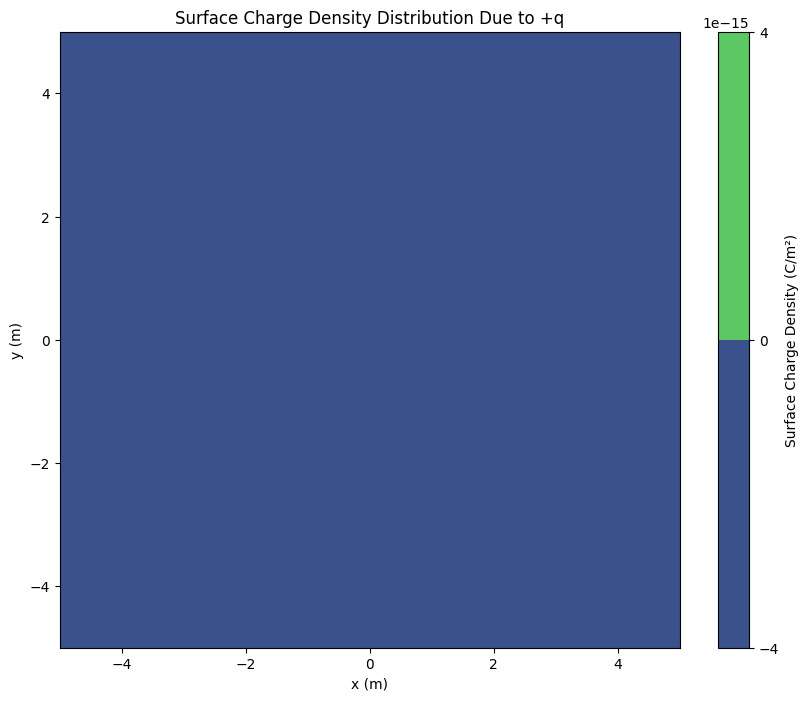

In [3]:
class PointCharge:
    def __init__(self, q, pos):
        self.q = q
        self.pos = np.array(pos)

    def potential(self, x, y, z):
        r = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)
        return self.q / (4 * np.pi * 8.854e-12 * r)

class ImageChargeSystem:
    def __init__(self, real_charge, image_charge):
        self.real_charge = real_charge
        self.image_charge = image_charge

    def potential(self, x, y, z):
        V_real = self.real_charge.potential(x, y, z)
        V_image = self.image_charge.potential(x, y, z)
        return V_real + V_image

    def surface_charge_density(self, z_plane=0, grid_points=100):
        x = np.linspace(-5, 5, grid_points)
        y = np.linspace(-5, 5, grid_points)
        X, Y = np.meshgrid(x, y)
        Z = np.full(X.shape, z_plane)
        V = self.potential(X, Y, Z)
        Ex, Ey = np.gradient(V, x, y)
        sigma = 8.854e-12 * (Ex + Ey)
        return X, Y, sigma
    
# Real charge
real_charge = PointCharge(q=1e-9, pos=[0, 0, 1])

# Image charge
image_charge = PointCharge(q=-1e-9, pos=[0, 0, -1])

# System
system = ImageChargeSystem(real_charge, image_charge)

# Surface charge density
X, Y, sigma = system.surface_charge_density()
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, sigma, levels=50, cmap='viridis')
plt.colorbar(label='Surface Charge Density (C/m²)')
plt.title('Surface Charge Density Distribution Due to +q')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()



### Due to Conducting Sphere

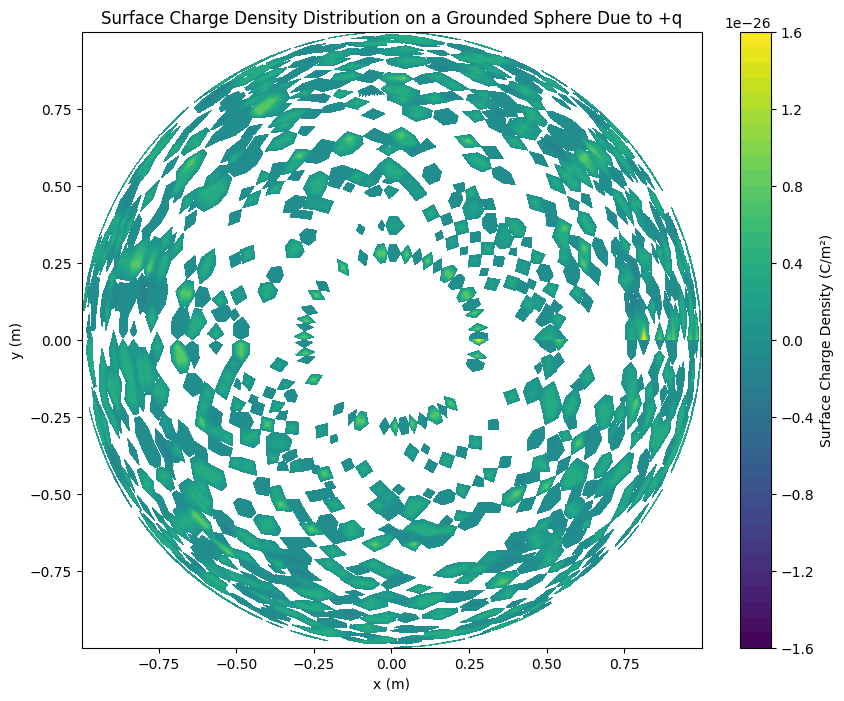

In [5]:
class SphereImageChargeSystem:
    def __init__(self, real_charge, sphere_radius):
        self.real_charge = real_charge
        self.sphere_radius = sphere_radius
        d = np.linalg.norm(real_charge.pos)
        self.image_charge = PointCharge(-real_charge.q * sphere_radius / d, 
                                        sphere_radius**2 / d * real_charge.pos / np.linalg.norm(real_charge.pos))

    def potential(self, x, y, z):
        V_real = self.real_charge.potential(x, y, z)
        V_image = self.image_charge.potential(x, y, z)
        return V_real + V_image

    def surface_charge_density(self, grid_points=100):
        theta = np.linspace(0, np.pi, grid_points)
        phi = np.linspace(0, 2 * np.pi, grid_points)
        theta, phi = np.meshgrid(theta, phi)
        
        X = self.sphere_radius * np.sin(theta) * np.cos(phi)
        Y = self.sphere_radius * np.sin(theta) * np.sin(phi)
        Z = self.sphere_radius * np.cos(theta)
        
        V = self.potential(X, Y, Z)
        r = np.sqrt(X**2 + Y**2 + Z**2)
        E_r = np.gradient(V, self.sphere_radius, axis=0)
        sigma = 8.854e-12 * E_r / r
        return theta, phi, sigma

# Real charge
real_charge = PointCharge(q=1e-9, pos=[0, 0, 2])

# System with sphere
sphere_radius = 1.0
system = SphereImageChargeSystem(real_charge, sphere_radius)

# Surface charge density
theta, phi, sigma = system.surface_charge_density()

# Convert to Cartesian coordinates for plotting
X = sphere_radius * np.sin(theta) * np.cos(phi)
Y = sphere_radius * np.sin(theta) * np.sin(phi)

# Plot the surface charge density distribution
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, sigma, levels=50, cmap='viridis')
plt.colorbar(label='Surface Charge Density (C/m²)')
plt.title('Surface Charge Density Distribution on a Grounded Sphere Due to +q')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


### Poisson Equation

In three dimensions, the Poisson equation is given by: $ \nabla^2 V = -\frac{\rho}{\epsilon_0} $ where 
∇
2
 is the Laplacian operator, 
V
 is the electric potential, 
ρ
 is the charge density, and 
ϵ
0
 is the permittivity of free space.

Step-by-Step Solution
Discretize the Domain:

Divide the continuous space into a discrete grid.

Finite Difference Method:

Approximate the Laplacian operator using finite differences.

For a 2D grid, the Laplacian of 
V
 at a grid point 
(
i
,
j
)
 is: $ \nabla^2 V_{i,j} \approx \frac{V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} - 4V_{i,j}}{h^2} $ where 
h
 is the grid spacing.
Iterative Solution:

Use an iterative method like the Jacobi, Gauss-Seidel, or Successive Over-Relaxation (SOR) method to solve the resulting system of linear equations.


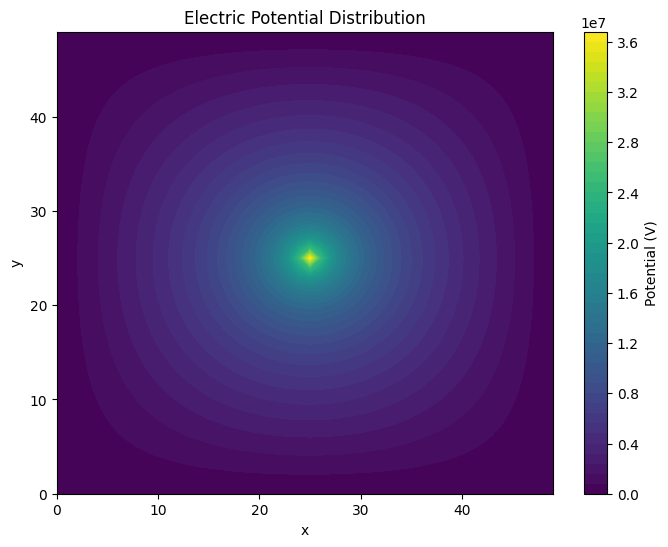

In [6]:
# Constants
epsilon_0 = 8.854e-12  # Permittivity of free space

# Grid parameters
N = 50  # Grid size
L = 1.0  # Domain size
h = L / (N-1)  # Grid spacing

# Charge distribution (source term)
rho = np.zeros((N, N))
rho[N//2, N//2] = 1.0  # Point charge at the center

# Initialize potential array
V = np.zeros((N, N))
def solve_poisson(V, rho, epsilon_0, h, tol=1e-5, max_iter=10000):
    for iteration in range(max_iter):
        V_new = np.copy(V)
        for i in range(1, N-1):
            for j in range(1, N-1):
                V_new[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + h**2 * rho[i, j] / epsilon_0)
        if np.linalg.norm(V_new - V, ord=np.inf) < tol:
            print(f'Converged in {iteration} iterations')
            break
        V = V_new
    return V

# Solve the Poisson equation
V = solve_poisson(V, rho, epsilon_0, h)
# Plot the potential
plt.figure(figsize=(8, 6))
plt.contourf(V, levels=50, cmap='viridis')
plt.colorbar(label='Potential (V)')
plt.title('Electric Potential Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
